## Convolutional Neural Network 

### Ramanathan Nachiappan
#### 50469166
#### Pattern Recognition

In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1bkcr55sW6BrcgKVPEGTb3vvhpnrklKKq?usp=sharing

Fill in cells below and fit neural networks for solving the binary classification task.

**Requirement**
- Python, Pytorch (Must), and all other necessary libraries
- **Just don't cheat, Thanks!**
- Sample output is to help you understand the task, and get an idea of what you have to do

## Task 1:

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


In [197]:
import time
import os
from tqdm import tqdm
from torchsummary import summary
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [198]:
import torch
import torch.nn as mm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

In [199]:
import torch.optim as op
import torchvision
import torchvision.transforms as trans
from torchvision.datasets import ImageFolder

The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

In [200]:
# Research on how to load google drive files into colab if you are using colab

# from google.colab import drive
# drive.mount('/content/drive')

In [201]:
# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):

train = 'D:/google chrome/Cats_and_Dogs-20230718T193003Z-001/Cats_and_Dogs/train'
val = 'D:/google chrome/Cats_and_Dogs-20230718T193003Z-001/Cats_and_Dogs/val'
test = 'D:/google chrome/Cats_and_Dogs-20230718T193003Z-001/Cats_and_Dogs/test'

train_dir = os.path.join(train)
test_dir = os.path.join(test)
val_dir = os.path.join(val)

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

# input shape
input_shape = (3, img_width, img_height)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels First"

# minibatch size
batch_size = 64
# train set size
nb_train_samples = 20000
# validation set size 
nb_validation_samples = 2490
# test set size
nb_test_samples = 2500

In [202]:
transformer = trans.Compose([trans.Resize((150, 150)),trans.ToTensor(),])

In [203]:
pet_train_data = ImageFolder(train_dir, transform = transformer)
pet_test_data = ImageFolder(test_dir, transform = transformer)
pet_val_data = ImageFolder(val_dir, transform = transformer)

pet_train_load = DataLoader(pet_train_data, batch_size = batch_size, shuffle = True)
pet_test_load = DataLoader(pet_test_data, batch_size = batch_size, shuffle = False)
pet_val_load = DataLoader(pet_val_data, batch_size = batch_size, shuffle = False)

## Prepare the data.

In [204]:
print(f"Found {len(pet_train_data)} images belonging to {len(pet_train_data.classes)} classes.")
print(f"Found {len(pet_test_data)} images belonging to {len(pet_test_data.classes)} classes.")
print(f"Found {len(pet_val_data)} images belonging to {len(pet_val_data.classes)} classes.")

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.


Class : cats


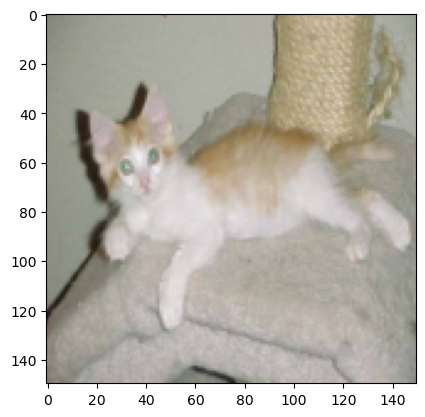

In [205]:
def display(img,label):
    plt.imshow(img.permute(1,2,0))
    print(f"Class : {pet_train_data.classes[label]}")
display(*pet_train_data[10])

Class : dogs


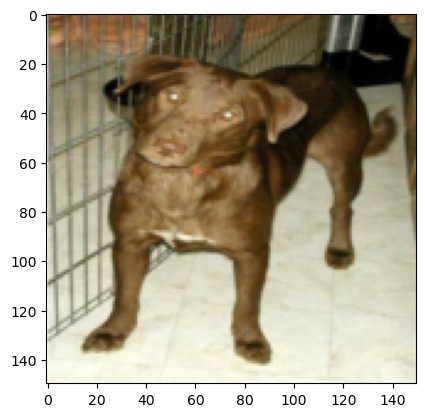

In [206]:
def display(img,label):
    plt.imshow(img.permute(1,2,0))
    print(f"Class : {pet_train_data.classes[label]}")
display(*pet_train_data[10001])

Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. flatten, which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use Dropout (0.5) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.


In [207]:
class CustomCNN(mm.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.convolution_layers = mm.Sequential(
            mm.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3), 
            mm.ReLU(),
            mm.MaxPool2d(kernel_size = 2),
            mm.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3),
            mm.ReLU(),
            mm.MaxPool2d(kernel_size = 2),
            mm.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
            mm.ReLU(),
            mm.MaxPool2d(kernel_size = 2)
        )
        con_out_size = self.con_out(input_shape)          
        self.forwarding_layers = mm.Sequential(
            mm.Linear(con_out_size, 64),
            mm.ReLU(),
            mm.Dropout(0.5),
            mm.Linear(64, 1),
            mm.Sigmoid()
        )
    
    def con_out(self, form):
        os = self.convolution_layers(torch.zeros(1, *form))
        return int(torch.prod(torch.tensor(os.size())))
    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = x.view(x.size(0), -1)
        x = self.forwarding_layers(x)
        return x

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)

# Binary Cross Entropy Loss for binary classification
lmode = mm.BCELoss()
opz = op.Adam(model.parameters(), lr=0.001)

In [14]:
# Training loop for 10
total_epochs = 10
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(total_epochs):
    model.train() 
    rl = 0.0
    cpt = 0
    with tqdm(total = len(pet_train_load.dataset), desc = f"Epoch {epoch + 1}/{total_epochs}", unit = "images") as pbar:
        for instances, labels in pet_train_load:
            instances, labels = instances.to(device), labels.to(device)
            opz.zero_grad()
            
            # Forward pass
            predictions = model(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            # Backward pass and optimization
            loss.backward()
            opz.step()
            
            rl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
            
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(instances.size(0))
            
    # Calculating average training loss and accuracy for this epoch
    avgtrainloss = rl / len(pet_train_load.dataset)
    trainacc = cpt / len(pet_train_load.dataset)
    
    train_losses.append(avgtrainloss)
    train_accuracies.append(trainacc)

# Validation loop
    model.eval() 
    vl = 0.0
    cpv = 0

    with torch.no_grad():
        for instances, labels in pet_val_load:
            instances, labels = instances.to(device), labels.to(device)
            predictions = model(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            vl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpv += (predictees == labels.float().unsqueeze(1)).sum().item()

    # Calculating average validation loss and accuracy for this epoch
    avgvalloss = vl / len(pet_val_load.dataset)
    valacc = cpv / len(pet_val_load.dataset)
    
    validation_losses.append(avgvalloss)
    validation_accuracies.append(valacc)

    print(f"Epoch {epoch + 1}/{total_epochs} - Training Loss: {avgtrainloss:.4f} - Training Accuracy:{trainacc:.4f} - Validation Loss: {avgvalloss:.4f} - Validation Accuracy: {valacc:.4f}")
    torch.save(model.state_dict(), './CNN10.pt')

Epoch 1/10: 100%|████████████████████████████████████████████████| 20000/20000 [09:05<00:00, 36.68images/s, Loss=0.503]


Epoch 1/10 - Training Loss: 0.6450 - Training Accuracy:0.6309 - Validation Loss: 0.5887 - Validation Accuracy: 0.6807


Epoch 2/10: 100%|████████████████████████████████████████████████| 20000/20000 [07:09<00:00, 46.56images/s, Loss=0.604]


Epoch 2/10 - Training Loss: 0.5529 - Training Accuracy:0.7251 - Validation Loss: 0.5053 - Validation Accuracy: 0.7695


Epoch 3/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:17<00:00, 77.63images/s, Loss=0.351]


Epoch 3/10 - Training Loss: 0.4825 - Training Accuracy:0.7719 - Validation Loss: 0.4652 - Validation Accuracy: 0.7803


Epoch 4/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.51images/s, Loss=0.447]


Epoch 4/10 - Training Loss: 0.4312 - Training Accuracy:0.8071 - Validation Loss: 0.4341 - Validation Accuracy: 0.7984


Epoch 5/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:17<00:00, 77.57images/s, Loss=0.266]


Epoch 5/10 - Training Loss: 0.4021 - Training Accuracy:0.8216 - Validation Loss: 0.4387 - Validation Accuracy: 0.8020


Epoch 6/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:18<00:00, 77.51images/s, Loss=0.424]


Epoch 6/10 - Training Loss: 0.3595 - Training Accuracy:0.8436 - Validation Loss: 0.4284 - Validation Accuracy: 0.8048


Epoch 7/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:19<00:00, 77.05images/s, Loss=0.263]


Epoch 7/10 - Training Loss: 0.3214 - Training Accuracy:0.8617 - Validation Loss: 0.4453 - Validation Accuracy: 0.8133


Epoch 8/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:18<00:00, 77.43images/s, Loss=0.379]


Epoch 8/10 - Training Loss: 0.2870 - Training Accuracy:0.8764 - Validation Loss: 0.4114 - Validation Accuracy: 0.8201


Epoch 9/10: 100%|████████████████████████████████████████████████| 20000/20000 [04:16<00:00, 77.82images/s, Loss=0.284]


Epoch 9/10 - Training Loss: 0.2455 - Training Accuracy:0.8974 - Validation Loss: 0.4290 - Validation Accuracy: 0.8225


Epoch 10/10: 100%|███████████████████████████████████████████████| 20000/20000 [04:16<00:00, 77.88images/s, Loss=0.137]


Epoch 10/10 - Training Loss: 0.2131 - Training Accuracy:0.9106 - Validation Loss: 0.4681 - Validation Accuracy: 0.8305


In [230]:
model.load_state_dict(torch.load('./CNN10.pt'))

<All keys matched successfully>

In [231]:
# Testing the model on the test set
model.eval()
tl = 0.0
cpt = 0

with torch.no_grad():
    for instances, labels in pet_test_load:
        instances, labels = instances.to(device), labels.to(device)
        predictions = model(instances)
        predictees = (predictions >= 0.5).float()
        cpt += (predictees == labels.float().unsqueeze(1)).sum().item()        
testacc = cpt / len(pet_test_load.dataset)
print(f"Accuracy on test data 10 Epochs: {testacc * 100:.2f}%")

Accuracy on test data 10 Epochs: 83.20%


In [21]:
# Training loop for 15
total_epochs = 15
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(total_epochs):
    model.train() 
    rl = 0.0
    cpt = 0
    with tqdm(total = len(pet_train_load.dataset), desc = f"Epoch {epoch + 1}/{total_epochs}", unit = "images") as pbar:
        for instances, labels in pet_train_load:
            instances, labels = instances.to(device), labels.to(device)
            opz.zero_grad()
            
            # Forward pass
            predictions = model(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            # Backward pass and optimization
            loss.backward()
            opz.step()
            
            rl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
            
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(instances.size(0))
            
    # Calculating average training loss and accuracy for this epoch
    avgtrainloss = rl / len(pet_train_load.dataset)
    trainacc = cpt / len(pet_train_load.dataset)
    
    train_losses.append(avgtrainloss)
    train_accuracies.append(trainacc)

# Validation loop
    model.eval() 
    vl = 0.0
    cpv = 0

    with torch.no_grad():
        for instances, labels in pet_val_load:
            instances, labels = instances.to(device), labels.to(device)
            predictions = model(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            vl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpv += (predictees == labels.float().unsqueeze(1)).sum().item()

    # Calculating average validation loss and accuracy for this epoch
    avgvalloss = vl / len(pet_val_load.dataset)
    valacc = cpv / len(pet_val_load.dataset)
    
    validation_losses.append(avgvalloss)
    validation_accuracies.append(valacc)

    print(f"Epoch {epoch + 1}/{total_epochs} - Training Loss: {avgtrainloss:.4f} - Training Accuracy:{trainacc:.4f} - Validation Loss: {avgvalloss:.4f} - Validation Accuracy: {valacc:.4f}")
    torch.save(model.state_dict(), './CNN15.pt')

Epoch 1/15: 100%|████████████████████████████████████████████████| 20000/20000 [04:58<00:00, 67.08images/s, Loss=0.166]


Epoch 1/15 - Training Loss: 0.1819 - Training Accuracy:0.9244 - Validation Loss: 0.4906 - Validation Accuracy: 0.8237


Epoch 2/15: 100%|█████████████████████████████████████████████████| 20000/20000 [04:21<00:00, 76.44images/s, Loss=0.15]


Epoch 2/15 - Training Loss: 0.1577 - Training Accuracy:0.9363 - Validation Loss: 0.5631 - Validation Accuracy: 0.8153


Epoch 3/15: 100%|████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.66images/s, Loss=0.191]


Epoch 3/15 - Training Loss: 0.1390 - Training Accuracy:0.9436 - Validation Loss: 0.5555 - Validation Accuracy: 0.8205


Epoch 4/15: 100%|████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.53images/s, Loss=0.224]


Epoch 4/15 - Training Loss: 0.1208 - Training Accuracy:0.9507 - Validation Loss: 0.5963 - Validation Accuracy: 0.8225


Epoch 5/15: 100%|███████████████████████████████████████████████| 20000/20000 [04:25<00:00, 75.46images/s, Loss=0.0558]


Epoch 5/15 - Training Loss: 0.1101 - Training Accuracy:0.9552 - Validation Loss: 0.6267 - Validation Accuracy: 0.8229


Epoch 6/15: 100%|███████████████████████████████████████████████| 20000/20000 [04:22<00:00, 76.12images/s, Loss=0.0347]


Epoch 6/15 - Training Loss: 0.0958 - Training Accuracy:0.9611 - Validation Loss: 0.6780 - Validation Accuracy: 0.8205


Epoch 7/15: 100%|████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.92images/s, Loss=0.166]


Epoch 7/15 - Training Loss: 0.0870 - Training Accuracy:0.9646 - Validation Loss: 0.7763 - Validation Accuracy: 0.8145


Epoch 8/15: 100%|████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.70images/s, Loss=0.028]


Epoch 8/15 - Training Loss: 0.0871 - Training Accuracy:0.9650 - Validation Loss: 0.8883 - Validation Accuracy: 0.8157


Epoch 9/15: 100%|███████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.84images/s, Loss=0.0435]


Epoch 9/15 - Training Loss: 0.0767 - Training Accuracy:0.9694 - Validation Loss: 0.8830 - Validation Accuracy: 0.8309


Epoch 10/15: 100%|██████████████████████████████████████████████| 20000/20000 [04:27<00:00, 74.81images/s, Loss=0.0402]


Epoch 10/15 - Training Loss: 0.0699 - Training Accuracy:0.9720 - Validation Loss: 1.0825 - Validation Accuracy: 0.8309


Epoch 11/15: 100%|██████████████████████████████████████████████| 20000/20000 [04:25<00:00, 75.46images/s, Loss=0.0552]


Epoch 11/15 - Training Loss: 0.0665 - Training Accuracy:0.9729 - Validation Loss: 1.0759 - Validation Accuracy: 0.8233


Epoch 12/15: 100%|███████████████████████████████████████████████| 20000/20000 [04:25<00:00, 75.40images/s, Loss=0.014]


Epoch 12/15 - Training Loss: 0.0661 - Training Accuracy:0.9738 - Validation Loss: 0.9764 - Validation Accuracy: 0.8293


Epoch 13/15: 100%|█████████████████████████████████████████████| 20000/20000 [04:27<00:00, 74.68images/s, Loss=0.00899]


Epoch 13/15 - Training Loss: 0.0559 - Training Accuracy:0.9764 - Validation Loss: 1.3426 - Validation Accuracy: 0.8261


Epoch 14/15: 100%|██████████████████████████████████████████████| 20000/20000 [05:09<00:00, 64.57images/s, Loss=0.0584]


Epoch 14/15 - Training Loss: 0.0630 - Training Accuracy:0.9765 - Validation Loss: 1.2217 - Validation Accuracy: 0.8201


Epoch 15/15: 100%|██████████████████████████████████████████████| 20000/20000 [04:56<00:00, 67.53images/s, Loss=0.0342]


Epoch 15/15 - Training Loss: 0.0572 - Training Accuracy:0.9768 - Validation Loss: 1.3561 - Validation Accuracy: 0.8177


In [232]:
model.load_state_dict(torch.load('./CNN15.pt'))

<All keys matched successfully>

In [233]:
# Testing the model on the test set
model.eval()
tl = 0.0
cpt = 0

with torch.no_grad():
    for instances, labels in pet_test_load:
        instances, labels = instances.to(device), labels.to(device)
        predictions = model(instances)
        predictees = (predictions >= 0.5).float()
        cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
testacc = cpt / len(pet_test_load.dataset)
print(f"Accuracy on test data 15 Epochs: {testacc * 100:.2f}%")

Accuracy on test data 15 Epochs:: 82.32%


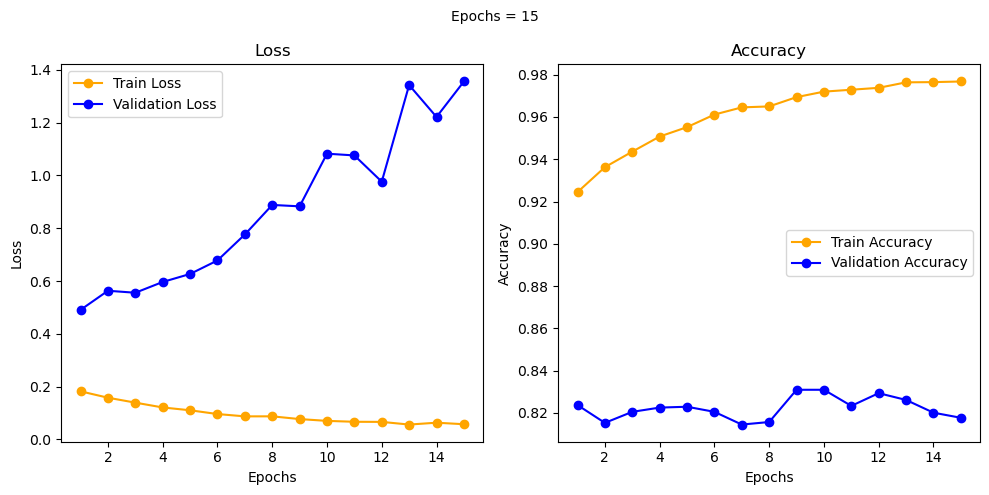

In [24]:
epochs = range(1, total_epochs + 1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].plot(epochs, train_losses, label='Train Loss', linestyle='-', marker='o', color='orange')
axes[0].plot(epochs, validation_losses, label='Validation Loss', linestyle='-', marker='o', color='blue')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-', marker='o', color='orange')
axes[1].plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='-', marker='o', color='blue')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

fig.suptitle('CNN Epochs = 15', fontsize = 10)
plt.tight_layout()
plt.show()

In [25]:
# Training loop for 20
total_epochs = 20
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(total_epochs):
    model.train() 
    rl = 0.0
    cpt = 0
    with tqdm(total = len(pet_train_load.dataset), desc = f"Epoch {epoch + 1}/{total_epochs}", unit = "images") as pbar:
        for instances, labels in pet_train_load:
            instances, labels = instances.to(device), labels.to(device)
            opz.zero_grad()
            
            # Forward pass
            predictions = model(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            # Backward pass and optimization
            loss.backward()
            opz.step()
            
            rl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
            
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(instances.size(0))
            
    # Calculating average training loss and accuracy for this epoch
    avgtrainloss = rl / len(pet_train_load.dataset)
    trainacc = cpt / len(pet_train_load.dataset)
    
    train_losses.append(avgtrainloss)
    train_accuracies.append(trainacc)

    # Validation loop
    model.eval() 
    vl = 0.0
    cpv = 0

    with torch.no_grad():
        for instances, labels in pet_val_load:
            instances, labels = instances.to(device), labels.to(device)
            predictions = model(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            vl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpv += (predictees == labels.float().unsqueeze(1)).sum().item()

    # Calculating average validation loss and accuracy for this epoch
    avgvalloss = vl / len(pet_val_load.dataset)
    valacc = cpv / len(pet_val_load.dataset)
    
    validation_losses.append(avgvalloss)
    validation_accuracies.append(valacc)

    print(f"Epoch {epoch + 1}/{total_epochs} - Training Loss: {avgtrainloss:.4f} - Training Accuracy:{trainacc:.4f} - Validation Loss: {avgvalloss:.4f} - Validation Accuracy: {valacc:.4f}")
    torch.save(model.state_dict(), './CNN20.pt')

Epoch 1/20: 100%|████████████████████████████████████████████████| 20000/20000 [04:33<00:00, 73.11images/s, Loss=0.036]


Epoch 1/20 - Training Loss: 0.0529 - Training Accuracy:0.9799 - Validation Loss: 1.0376 - Validation Accuracy: 0.8205


Epoch 2/20: 100%|███████████████████████████████████████████████| 20000/20000 [04:27<00:00, 74.63images/s, Loss=0.0172]


Epoch 2/20 - Training Loss: 0.0539 - Training Accuracy:0.9784 - Validation Loss: 1.2453 - Validation Accuracy: 0.8309


Epoch 3/20: 100%|███████████████████████████████████████████████| 20000/20000 [04:30<00:00, 74.05images/s, Loss=0.0165]


Epoch 3/20 - Training Loss: 0.0606 - Training Accuracy:0.9755 - Validation Loss: 1.1957 - Validation Accuracy: 0.8313


Epoch 4/20: 100%|████████████████████████████████████████████████| 20000/20000 [04:29<00:00, 74.11images/s, Loss=0.114]


Epoch 4/20 - Training Loss: 0.0555 - Training Accuracy:0.9774 - Validation Loss: 1.1293 - Validation Accuracy: 0.8197


Epoch 5/20: 100%|███████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.97images/s, Loss=0.0805]


Epoch 5/20 - Training Loss: 0.0555 - Training Accuracy:0.9766 - Validation Loss: 1.4237 - Validation Accuracy: 0.8197


Epoch 6/20: 100%|███████████████████████████████████████████████| 20000/20000 [05:06<00:00, 65.34images/s, Loss=0.0339]


Epoch 6/20 - Training Loss: 0.0532 - Training Accuracy:0.9781 - Validation Loss: 1.6648 - Validation Accuracy: 0.8225


Epoch 7/20: 100%|███████████████████████████████████████████████| 20000/20000 [05:01<00:00, 66.35images/s, Loss=0.0196]


Epoch 7/20 - Training Loss: 0.0438 - Training Accuracy:0.9815 - Validation Loss: 1.3616 - Validation Accuracy: 0.8092


Epoch 8/20: 100%|███████████████████████████████████████████████| 20000/20000 [04:32<00:00, 73.29images/s, Loss=0.0572]


Epoch 8/20 - Training Loss: 0.0513 - Training Accuracy:0.9795 - Validation Loss: 1.7807 - Validation Accuracy: 0.8181


Epoch 9/20: 100%|███████████████████████████████████████████████| 20000/20000 [04:32<00:00, 73.33images/s, Loss=0.0192]


Epoch 9/20 - Training Loss: 0.0466 - Training Accuracy:0.9817 - Validation Loss: 1.7641 - Validation Accuracy: 0.8221


Epoch 10/20: 100%|██████████████████████████████████████████████| 20000/20000 [04:31<00:00, 73.76images/s, Loss=0.0244]


Epoch 10/20 - Training Loss: 0.0487 - Training Accuracy:0.9811 - Validation Loss: 2.2154 - Validation Accuracy: 0.8257


Epoch 11/20: 100%|██████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.92images/s, Loss=0.0376]


Epoch 11/20 - Training Loss: 0.0467 - Training Accuracy:0.9808 - Validation Loss: 1.7822 - Validation Accuracy: 0.8217


Epoch 12/20: 100%|██████████████████████████████████████████████| 20000/20000 [04:32<00:00, 73.38images/s, Loss=0.0189]


Epoch 12/20 - Training Loss: 0.0517 - Training Accuracy:0.9793 - Validation Loss: 2.0442 - Validation Accuracy: 0.8285


Epoch 13/20: 100%|██████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.85images/s, Loss=0.0666]


Epoch 13/20 - Training Loss: 0.0462 - Training Accuracy:0.9808 - Validation Loss: 1.7290 - Validation Accuracy: 0.8213


Epoch 14/20: 100%|██████████████████████████████████████████████| 20000/20000 [04:33<00:00, 73.24images/s, Loss=0.0335]


Epoch 14/20 - Training Loss: 0.0452 - Training Accuracy:0.9815 - Validation Loss: 1.6074 - Validation Accuracy: 0.8124


Epoch 15/20: 100%|███████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.93images/s, Loss=0.114]


Epoch 15/20 - Training Loss: 0.0397 - Training Accuracy:0.9843 - Validation Loss: 2.4808 - Validation Accuracy: 0.8333


Epoch 16/20: 100%|█████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.81images/s, Loss=0.00292]


Epoch 16/20 - Training Loss: 0.0496 - Training Accuracy:0.9816 - Validation Loss: 2.1577 - Validation Accuracy: 0.8293


Epoch 17/20: 100%|████████████████████████████████████████████| 20000/20000 [04:31<00:00, 73.58images/s, Loss=0.000244]


Epoch 17/20 - Training Loss: 0.0464 - Training Accuracy:0.9815 - Validation Loss: 1.9311 - Validation Accuracy: 0.8225


Epoch 18/20: 100%|██████████████████████████████████████████████| 20000/20000 [04:43<00:00, 70.63images/s, Loss=0.0367]


Epoch 18/20 - Training Loss: 0.0416 - Training Accuracy:0.9818 - Validation Loss: 2.0763 - Validation Accuracy: 0.8177


Epoch 19/20: 100%|██████████████████████████████████████████████| 20000/20000 [05:04<00:00, 65.73images/s, Loss=0.0416]


Epoch 19/20 - Training Loss: 0.0435 - Training Accuracy:0.9848 - Validation Loss: 2.3163 - Validation Accuracy: 0.8177


Epoch 20/20: 100%|███████████████████████████████████████████████| 20000/20000 [05:00<00:00, 66.60images/s, Loss=0.386]


Epoch 20/20 - Training Loss: 0.0487 - Training Accuracy:0.9812 - Validation Loss: 1.6496 - Validation Accuracy: 0.8116


In [234]:
model.load_state_dict(torch.load('./CNN20.pt'))

<All keys matched successfully>

In [235]:
# Testing the model on the test set
model.eval()
tl = 0.0
cpt = 0

with torch.no_grad():
    for instances, labels in pet_test_load:
        instances, labels = instances.to(device), labels.to(device)
        predictions = model(instances)
        predictees = (predictions >= 0.5).float()
        cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
testacc = cpt / len(pet_test_load.dataset)
print(f"Accuracy on test data 20 Epochs: {testacc * 100:.2f}%")

Accuracy on test data 20 Epochs: 82.76%


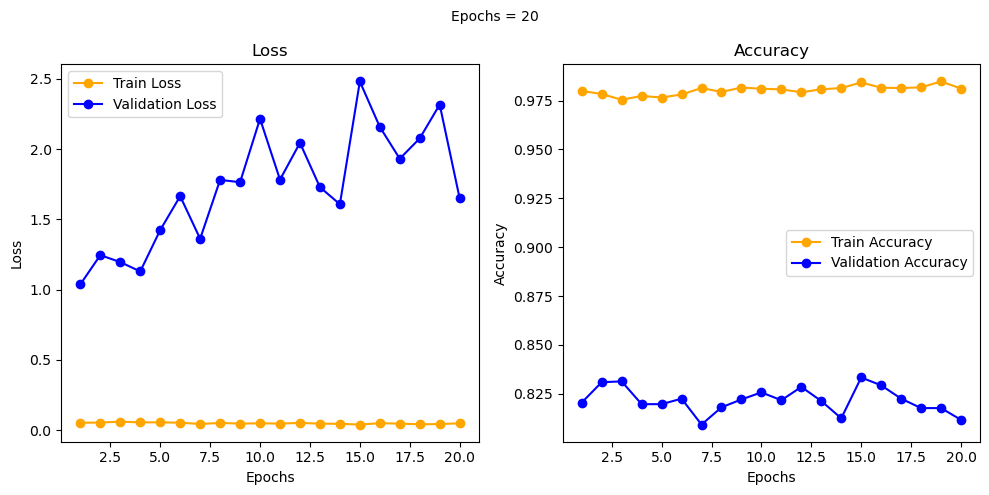

In [28]:
epochs = range(1, total_epochs + 1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].plot(epochs, train_losses, label='Train Loss', linestyle='-', marker='o', color='orange')
axes[0].plot(epochs, validation_losses, label='Validation Loss', linestyle='-', marker='o', color='blue')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-', marker='o', color='orange')
axes[1].plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='-', marker='o', color='blue')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

fig.suptitle('CNN Epochs = 20', fontsize = 10)
plt.tight_layout()
plt.show()

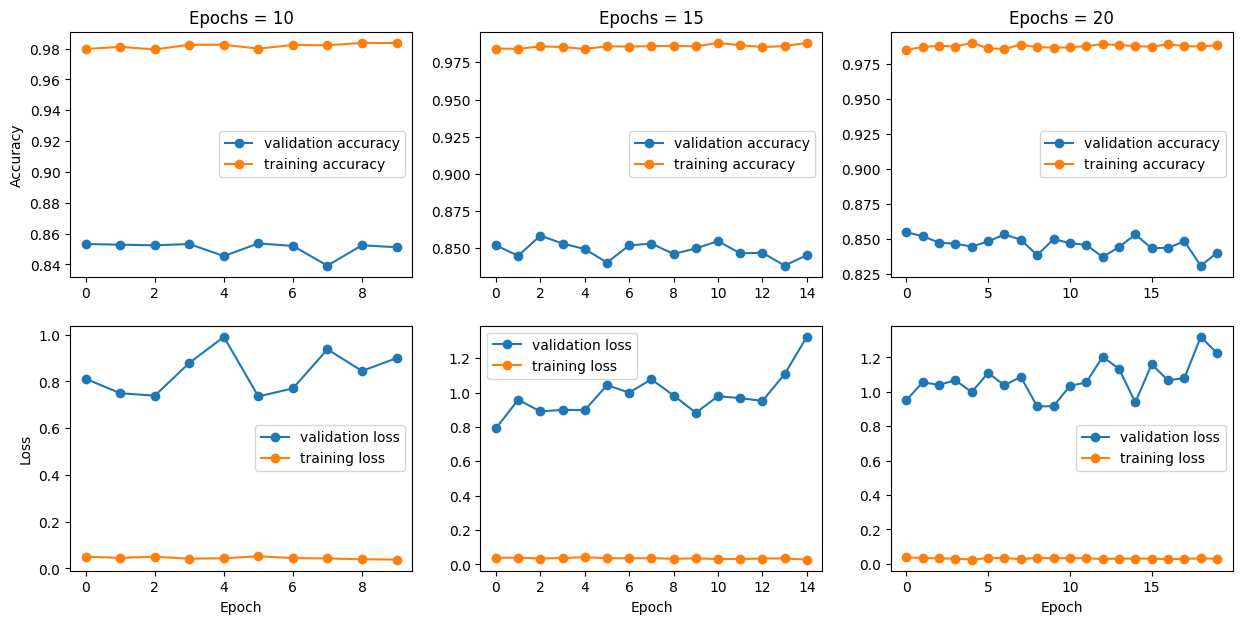

Let's try to improve the quality of recognition, using the method of transfer lerning. 

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2

1. Build and fit Transfer Learning model using pre-trained VGG16-model weights.
2. Evaluate accuracy on test data for p.1 and p.2
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)
4. Check the performance of your model with the custom image of cat or dog (so the model will tell which class this image belongs to). Develop the function for the inference of the best algorithm.

In [236]:
from torchvision.models import vgg16
VGG = vgg16(pretrained = True)
summary(VGG, input_size = input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [237]:
for hp in VGG.parameters():
    hp.requires_grad = False

In [238]:
nof = VGG.classifier[6].in_features
VGG.classifier[6] = mm.Sequential(
    mm.Linear(nof, 256),
    mm.ReLU(),
    mm.Dropout(0.5),
    mm.Linear(256, 1),
    mm.Sigmoid()
)

In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG = VGG.to(device)

In [240]:
summary(VGG, input_size = input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [241]:
lmode = mm.BCELoss()
opz = op.Adam(VGG.parameters(), lr=0.001)

In [27]:
# Training loop for vgg16
total_epochs = 4
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(total_epochs):
    VGG.train() 
    rl = 0.0
    cpt = 0
    with tqdm(total = len(pet_train_load.dataset), desc = f"Epoch {epoch + 1}/{total_epochs}", unit = "images") as pbar:
        for instances, labels in pet_train_load:
            instances, labels = instances.to(device), labels.to(device)
            opz.zero_grad()
            
            # Forward pass
            predictions = VGG(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            # Backward pass and optimization
            loss.backward()
            opz.step()
            
            rl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
            
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(instances.size(0))
            
    # Calculating average training loss and accuracy for this epoch
    avgtrainloss = rl / len(pet_train_load.dataset)
    trainacc = cpt / len(pet_train_load.dataset)
    
    train_losses.append(avgtrainloss)
    train_accuracies.append(trainacc)

# Validation loop
    VGG.eval() 
    vl = 0.0
    cpv = 0

    with torch.no_grad():
        for instances, labels in pet_val_load:
            instances, labels = instances.to(device), labels.to(device)
            predictions = VGG(instances)
            loss = lmode(predictions, labels.float().unsqueeze(1))
            
            vl += loss.item() * instances.size(0)
            predictees = (predictions >= 0.5).float()
            cpv += (predictees == labels.float().unsqueeze(1)).sum().item()

    # Calculating average validation loss and accuracy for this epoch
    avgvalloss = vl / len(pet_val_load.dataset)
    valacc = cpv / len(pet_val_load.dataset)
    
    validation_losses.append(avgvalloss)
    validation_accuracies.append(valacc)

    print(f"Epoch {epoch + 1}/{total_epochs} - Training Loss: {avgtrainloss:.4f} - Training Accuracy:{trainacc:.4f} - Validation Loss: {avgvalloss:.4f} - Validation Accuracy: {valacc:.4f}")
    torch.save(VGG.state_dict(), './VGG16.pt')

Epoch 1/4: 100%|█████████████████████████████████████████████████| 20000/20000 [46:03<00:00,  7.24images/s, Loss=0.072]


Epoch 1/4 - Training Loss: 0.1701 - Training Accuracy:0.9304 - Validation Loss: 0.1273 - Validation Accuracy: 0.9478


Epoch 2/4: 100%|████████████████████████████████████████████████| 20000/20000 [40:57<00:00,  8.14images/s, Loss=0.0774]


Epoch 2/4 - Training Loss: 0.1463 - Training Accuracy:0.9403 - Validation Loss: 0.1259 - Validation Accuracy: 0.9478


Epoch 3/4: 100%|█████████████████████████████████████████████████| 20000/20000 [40:50<00:00,  8.16images/s, Loss=0.064]


Epoch 3/4 - Training Loss: 0.1381 - Training Accuracy:0.9453 - Validation Loss: 0.1195 - Validation Accuracy: 0.9510


Epoch 4/4: 100%|█████████████████████████████████████████████████| 20000/20000 [41:08<00:00,  8.10images/s, Loss=0.199]


Epoch 4/4 - Training Loss: 0.1306 - Training Accuracy:0.9466 - Validation Loss: 0.1189 - Validation Accuracy: 0.9506


In [243]:
VGG.load_state_dict(torch.load('./VGG16.pt'))

<All keys matched successfully>

In [244]:
# Testing the model on the test set
VGG.eval()
tl = 0.0
cpt = 0

with torch.no_grad():
    for instances, labels in pet_test_load:
        instances, labels = instances.to(device), labels.to(device)
        predictions = VGG(instances)
        predictees = (predictions >= 0.5).float()
        cpt += (predictees == labels.float().unsqueeze(1)).sum().item()
testacc = cpt / len(pet_test_load.dataset)
print(f"Accuracy on test data VGG 4 Epochs: {testacc * 100:.2f}%")

Accuracy on test data VGG 4 Epochs: 94.84%


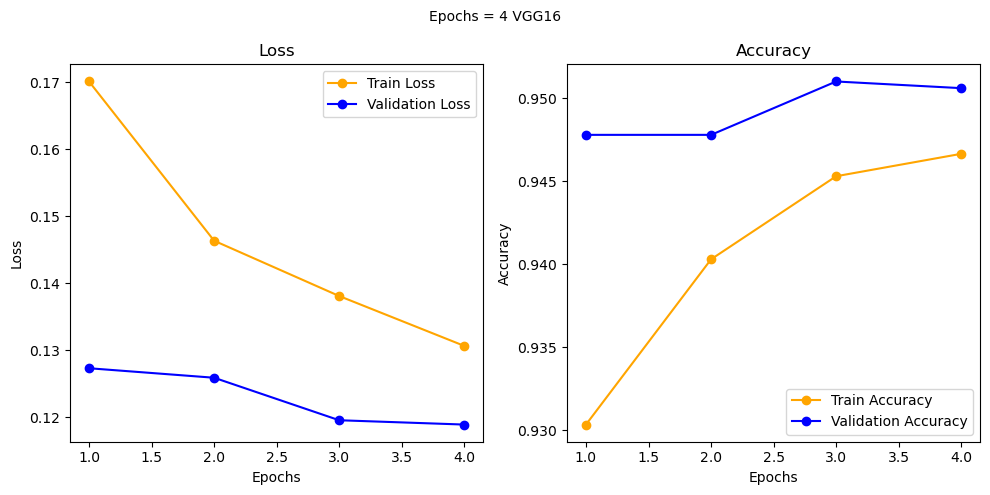

In [31]:
epochs = range(1, total_epochs + 1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].plot(epochs, train_losses, label='Train Loss', linestyle='-', marker='o', color='orange')
axes[0].plot(epochs, validation_losses, label='Validation Loss', linestyle='-', marker='o', color='blue')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-', marker='o', color='orange')
axes[1].plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='-', marker='o', color='blue')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

fig.suptitle('Epochs = 4 VGG16', fontsize = 10)
plt.tight_layout()
plt.show()

# Save and Showcase how good is your model

In [245]:
VGG.load_state_dict(torch.load('./VGG16.pt'))

<All keys matched successfully>

In [246]:
def load(path):
    image = Image.open(path)
    image = transformer(image).unsqueeze(0)
    return image

In [247]:
test1_path = "./1.jpg"
test2_path = "./2.jpg"

In [248]:
image1 = load(test1_path)
image2 = load(test2_path)

In [249]:
with torch.no_grad():
    VGG.eval()
    output1 = VGG(image1)
    output2 = VGG(image2)
probabilities1 = torch.sigmoid(output1)
probabilities2 = torch.sigmoid(output2)

predicted_class1 = 'dog' if probabilities1.item() >= 0.51 else 'cat'
predicted_class2 = 'dog' if probabilities2.item() >= 0.51 else 'cat'

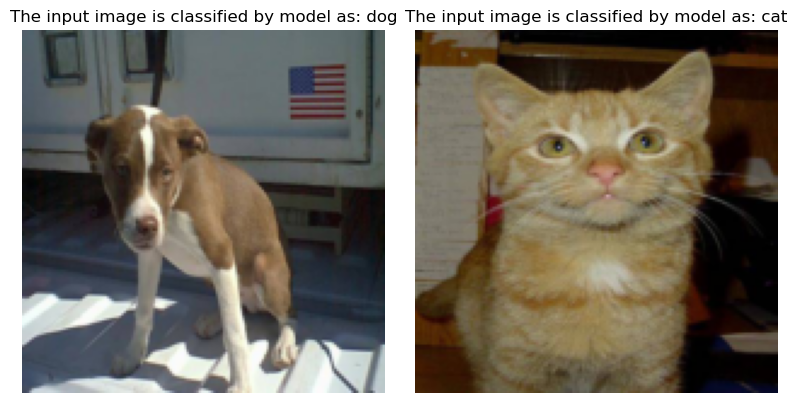

In [250]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image1.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f'The input image is classified by model as: {predicted_class1}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f'The input image is classified by model as: {predicted_class2}')
plt.axis('off')

plt.tight_layout()
plt.show()

In [251]:
# 50469166
# Ramanathan Nachiappan